In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from sys import path
path.insert(0, "lib")
from minima import *
from colorline import colorline

%load_ext autoreload
%autoreload 2

In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ExponentialConvectionTerm

from fipy.tools import numerix

# Simple diffusion example
* Based on [this example](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.mesh1D.html)
* Generic info about numerical schemes [here](https://www.ctcms.nist.gov/fipy/documentation/numerical/scheme.html#sec-numericalschemes)

In [3]:
nx = 50

dx = 1.

mesh = Grid1D(nx=nx, dx=dx)

In [4]:
phi = CellVariable(mesh=mesh, name=r"$\phi$")

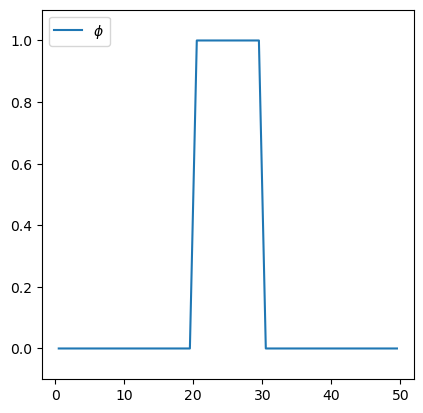

In [5]:
phi.value = 0.

L = 50 
x = mesh.cellCenters[0]

phi.setValue(1., where=(x > L/2. - L/10.) & (x < L/2. + L/10.))

viewer = Viewer(vars=phi, datamin=-0.1, datamax=1.1)

In [6]:
# non-uniform diffusion coefficient
D = FaceVariable(mesh=mesh, value=1.0)
X = mesh.faceCenters[0]
D.setValue(0.1, where=(L / 4. <= X) & (X < 3. * L / 4.))

# no boundary conditions: default no flux bc

# valueLeft = 1
# valueRight = 0
# phi.constrain(valueRight, mesh.facesRight)
# phi.constrain(valueLeft, mesh.facesLeft)

# explicit
eq = TransientTerm() == DiffusionTerm(D)

In [7]:
dt = 10. * dx**2 / (2 * D[0])
steps = 200

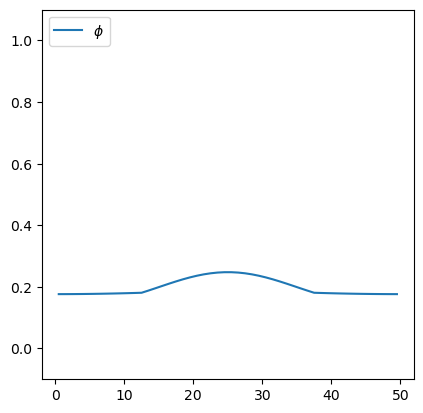

In [8]:
for step in range(steps):
    eq.solve(var=phi, dt=dt)
    viewer.plot()

# 1D linear model

In [193]:
nw = 100
L = 1.
mesh = Grid1D(nx=nw, dx=dw, Lx=L)

In [194]:
P = CellVariable(mesh=mesh, name=r"$P$")

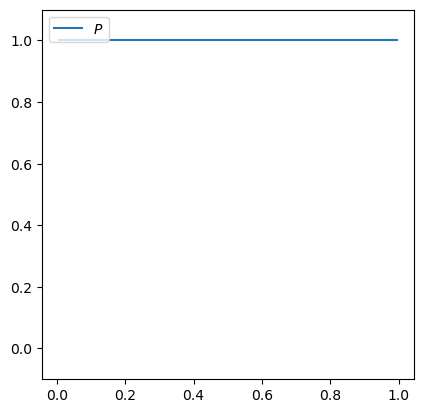

In [195]:
P.value = 0.

w = mesh.cellCenters[0]

# (unconventional normalization)
P.setValue(1.)

viewer = Viewer(vars=P, datamin=-0.1, datamax=1.1)

In [196]:
# non-uniform diffusion coefficient
# D = FaceVariable(mesh=mesh, value=1.0)
w = mesh.cellCenters[0]
w0 = .5
l = .02
v = 1.
ve = 1.
D2 = l*l*(v*ve*.5 + v*v*(w-w0)**2.)

W = mesh.faceCenters[0]
D1 = l*v*(l*v-1.)*(W - w0)
gradD2 = 2.*(l*v)**2.*(W-w0)
# unit vector
u = FaceVariable(mesh=mesh, value = 1., rank=1)

# explicit
eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = -D1 + gradD2))

In [197]:
dt = 2. * dx**2 / (2)
steps = 100

In [198]:
Ps = [P.copy()]
for step in range(steps):
    eq.solve(var=P, dt=dt)
    Ps.append(P.copy())

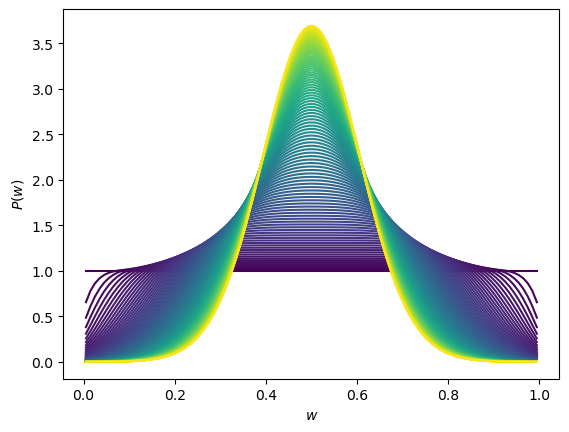

In [202]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(mesh.x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.savefig("dynamics_linear_model.png", bbox_inches="tight", dpi=150)

# 1D non-linear, singular model

In [10]:
nw = 300
dw = 1
L = 3.
mesh = Grid1D(nx=nw, dx=dw, Lx=L)

In [11]:
P = CellVariable(mesh=mesh, name=r"$P$")

In [34]:
P.value = 0.

w = mesh.cellCenters[0]

# (unconventional normalization)
P.setValue(1.)

In [35]:
# non-uniform diffusion coefficient
# D = FaceVariable(mesh=mesh, value=1.0)
w = mesh.cellCenters[0]
w0 = .5
l = .002
v = 1.
ve = 1.
D2 = .5*l**2*(1+2*(-2+w)**2*(-1+w)**4)*(5-8*w+3*w**2)**2

w = mesh.faceCenters[0]
D1 = l*(-1+w)*(-5+3*w)*(-((-2+w)*(-1+w)**2)+l*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w))))))))
gradD2 = 2*l**2*(-1+w)*(-5+3*w)*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w)))))))
# unit vector
u = FaceVariable(mesh=mesh, value = 1., rank=1)

# explicit
eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = -D1 + gradD2))

In [36]:
dt = 2. * dx**2 / (2)
steps = 5000

In [37]:
Ps = [P.copy()]
for step in range(steps):
    eq.solve(var=P, dt=dt)
    Ps.append(P.copy())

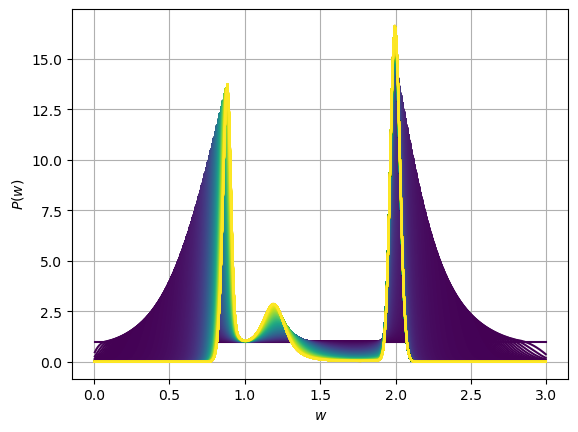

In [38]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(mesh.x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()